In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Read csv file
data = pd.read_csv('sample.csv')

# Partition factor and target variable
X = data.drop('Y', axis=1)  
y = data['Y']  

# Initialize random forest classifier
rf = RandomForestClassifier()

# Perform cross-validation of ten folds
scores = cross_val_score(rf, X, y, cv=10, scoring='accuracy')

# Print the score of each cross-validation
print("Cross-validation scores:", scores)

# Average accuracy and standard deviation of printing
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))





Cross-validation scores: [0.71153846 0.59615385 0.82692308 0.86538462 0.80769231 0.88461538
 0.80769231 0.84615385 0.80392157 0.78431373]
Accuracy: 0.79 (+/- 0.16)


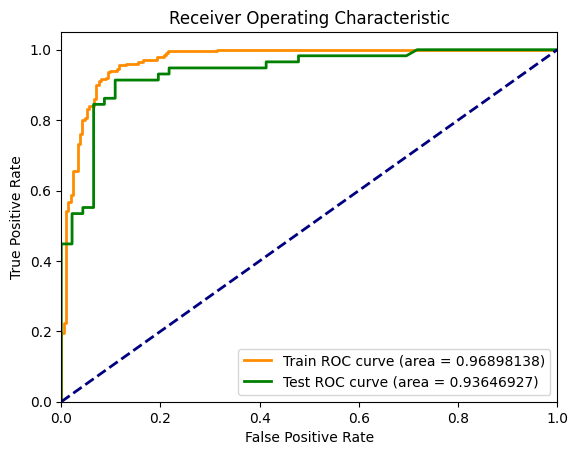

In [2]:
# Set the superparameter of random forest
rf_params = {
    'n_estimators': 159,  # Number of decision trees
    'max_depth': 8,  # Maximum depth of decision tree
    'min_samples_split': 0.10350645380971991,  # Minimum number of samples required to split internal nodes
    'min_samples_leaf': 1,  # Minimum number of samples required for leaf nodes
    'max_features':  20,  # can be changed to' sqrt', None,' log2', and the number of features to be considered when finding the best segmentation.
    'random_state': 42  #  Random seed
} 

# Set the superparameter of random forest through dictionary
rf = RandomForestClassifier(**rf_params)

# Divide data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#这个位置的random_state是确保随机种子数一样而设置，为了确保每次跑出的模型都一样。

# Training Random Forest Model
rf.fit(X_train, y_train)

# Use the trained model to make predictions
y_train_pred_proba = rf.predict_proba(X_train)[:, 1]
y_test_pred_proba = rf.predict_proba(X_test)[:, 1]

# Calculate FPR and TPR and threshold.
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba)

#  Calculate AUC
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

#  Draw ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.8f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Test ROC curve (area = %0.8f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('D:\\Desktop\\roc_curve.png')
plt.show()


In [47]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# Define optimization function
def rf_objective(params):
    clf = RandomForestClassifier(n_estimators=int(params['n_estimators']),
                                 max_depth=int(params['max_depth']),
                                 min_samples_split=params['min_samples_split'],
                                 min_samples_leaf=params['min_samples_leaf'],
                                 max_features=int(params['max_features']))
    
    # Cross-validate on the dataset and return loss.
    loss = -cross_val_score(clf,X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': loss, 'status': STATUS_OK}

#  Define parameter space
param_space = {'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
               'max_depth': hp.quniform('max_depth', 1, 10, 1),
               'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
              'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 3, 4, 5]),
               'max_features': hp.quniform('max_features', 1, 22, 1)}

#  Perform Bayesian optimization
trials = Trials()
best = fmin(fn=rf_objective, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)

print("最佳参数：", best)

100%|█████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/trial, best loss: -0.8358213341169556]
最佳参数： {'max_depth': 8.0, 'max_features': 20.0, 'min_samples_leaf': 1, 'min_samples_split': 0.10350645380971991, 'n_estimators': 159.0}


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#  Use the trained model to make predictions
y_pred = rf.predict(X)


# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y, y_pred)

# Calculate other classification indicators
accuracy = accuracy_score(y, y_pred)

precision = precision_score(y, y_pred)

recall = recall_score(y, y_pred)

f1_score = f1_score(y, y_pred)

# Output confusion matrix and classification index
print("Confusion Matrix :")
print(confusion_matrix)
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1 Score :", f1_score)

Confusion Matrix :
[[219  40]
 [ 14 245]]
Accuracy : 0.8957528957528957
Precision : 0.8596491228070176
Recall : 0.9459459459459459
F1 Score : 0.9007352941176471


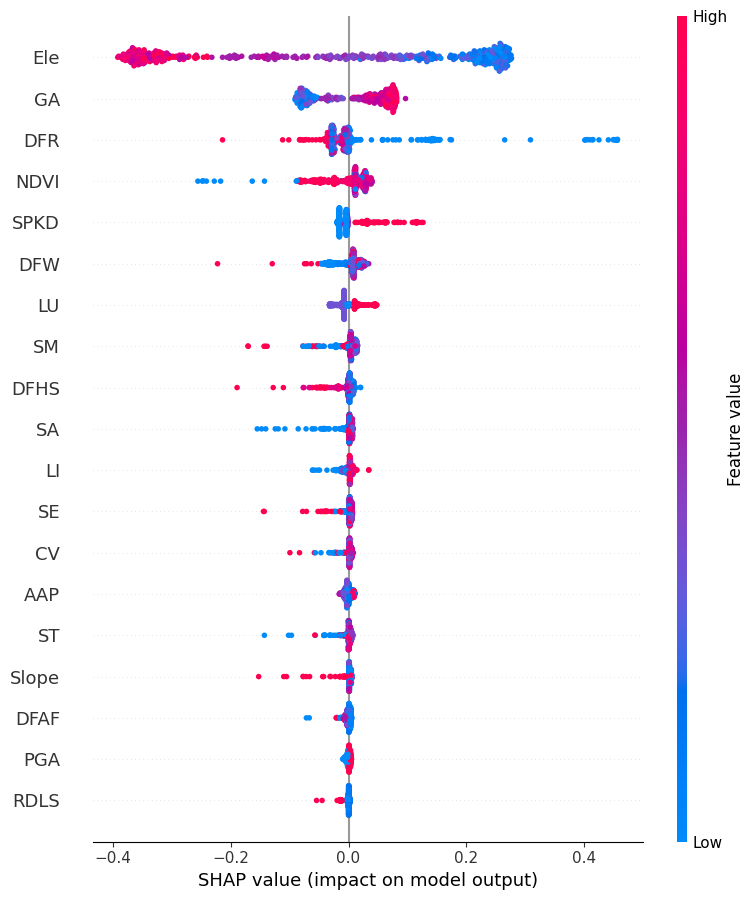

In [3]:

# Draw a SHAP diagram
cols = ['SA', 'CV', 'Ele', 'DFAF', 'DFHS', 'DFR', 'DFW', 'GA', 'LI', 'LU', 'NDVI', 'PGA', 'AAP', 'SE', 'SPKD', 'Slope', 'SM', 'ST', 'RDLS']
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)[:, :, 1]  # Select the SHAP value of the second category (positive category)

plt.figure(figsize=(10, 6))  
shap.summary_plot(shap_values, X, feature_names=cols, show=False)


plt.savefig('D:\\Desktop\\factor.png', format='png')

#plt.show()  


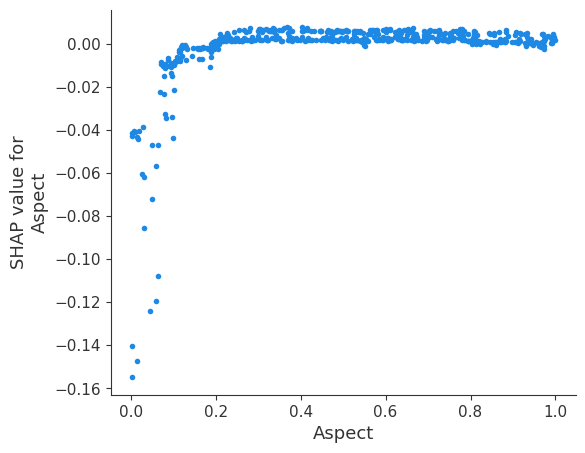

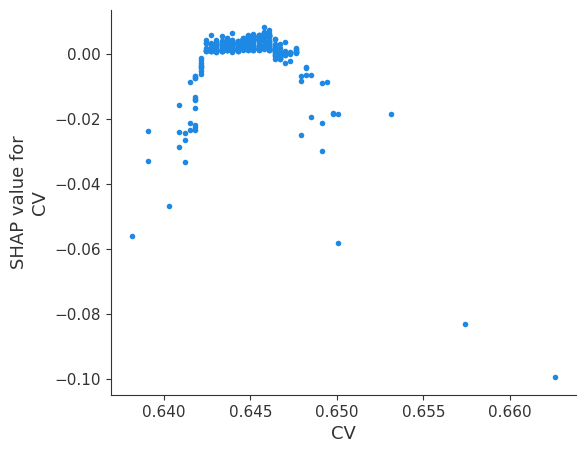

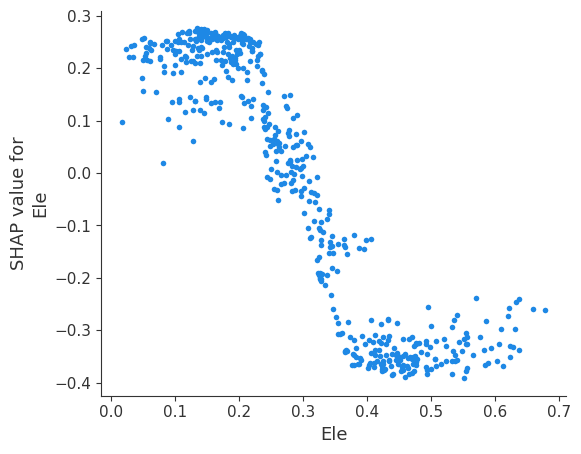

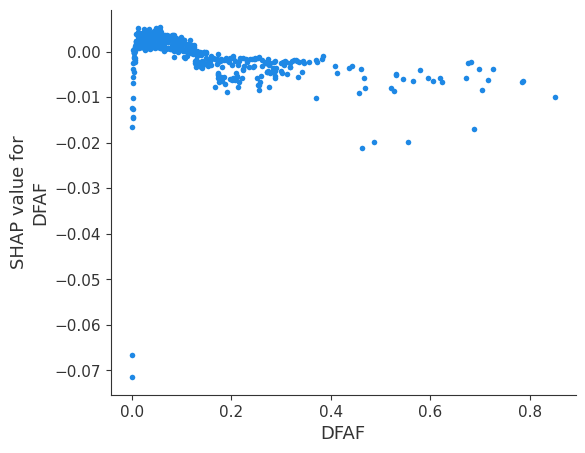

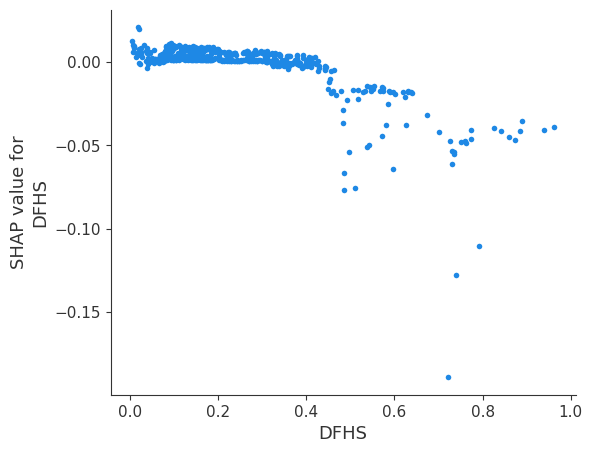

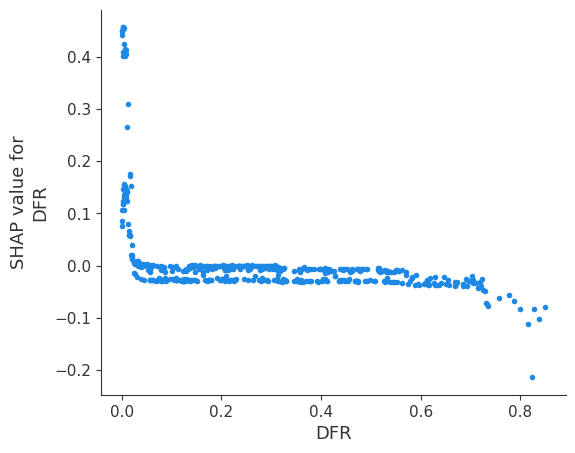

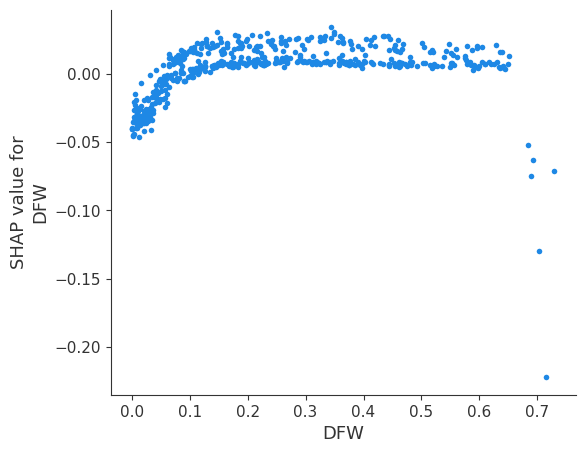

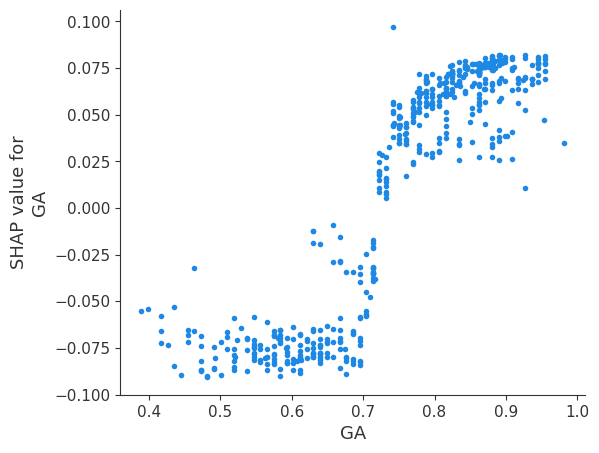

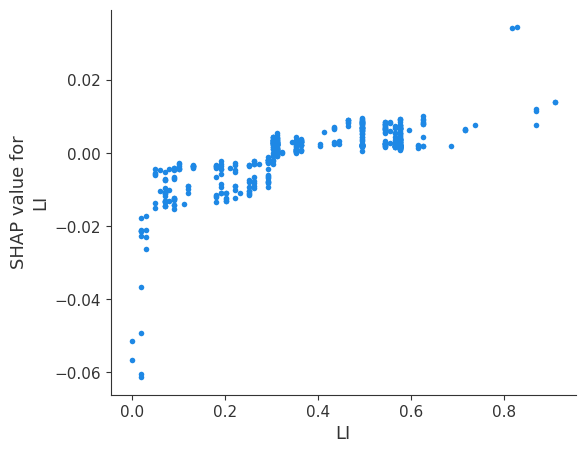

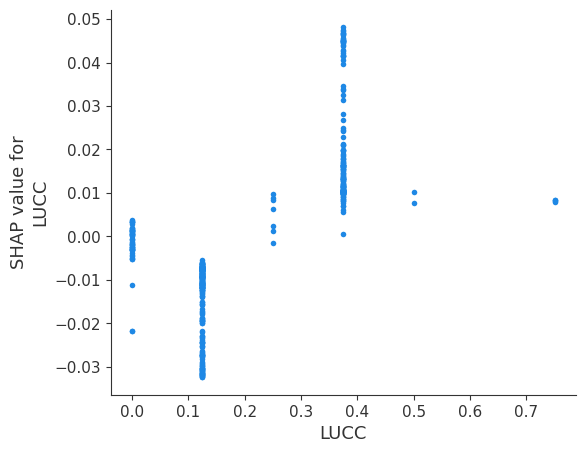

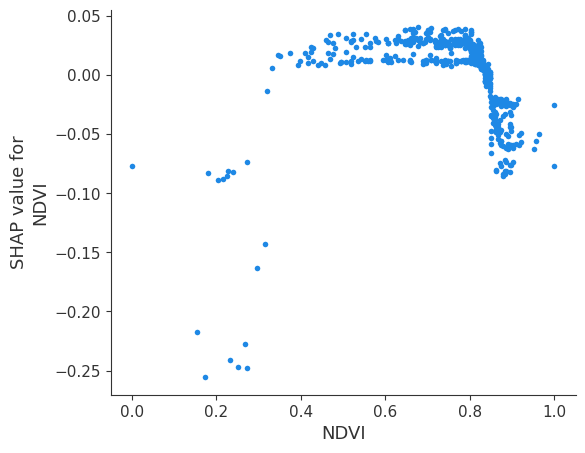

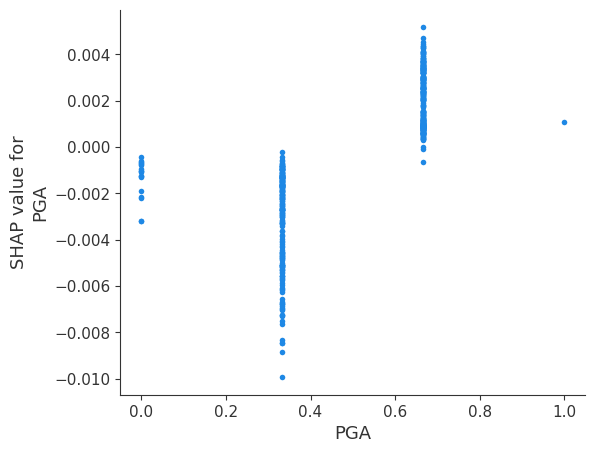

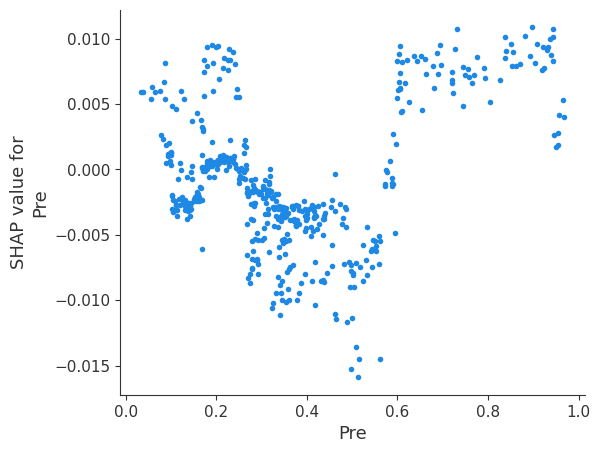

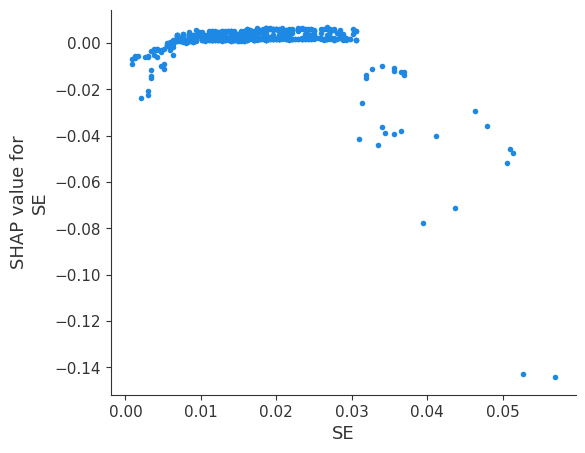

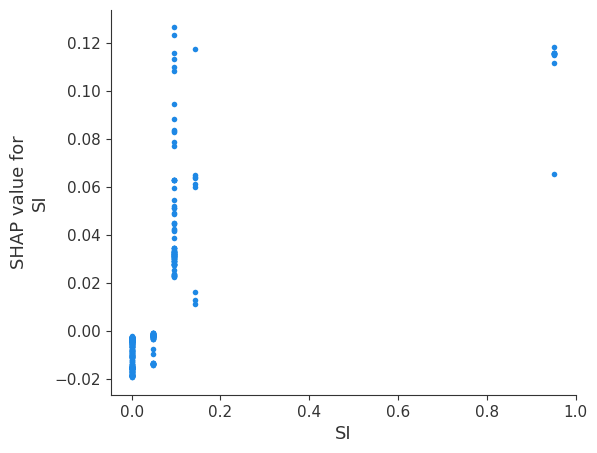

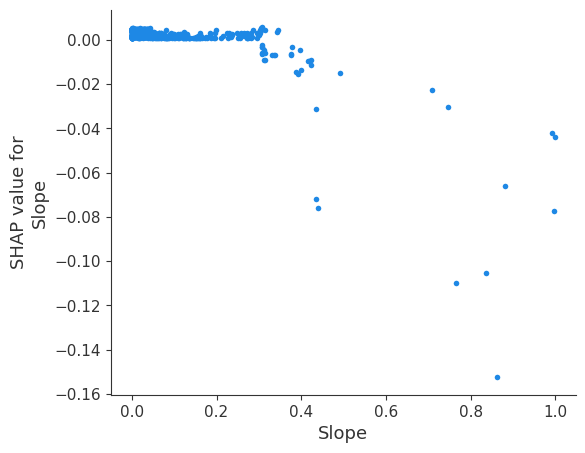

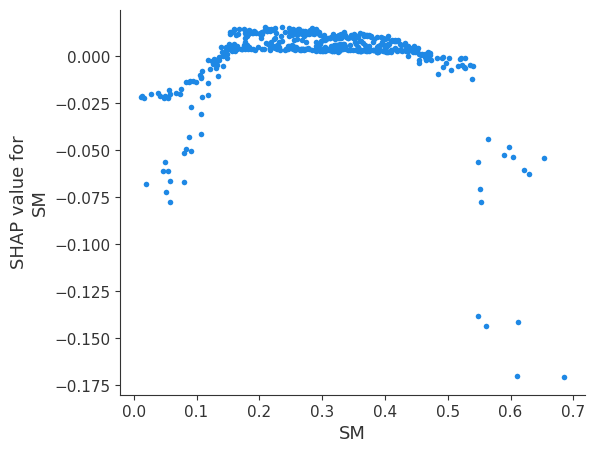

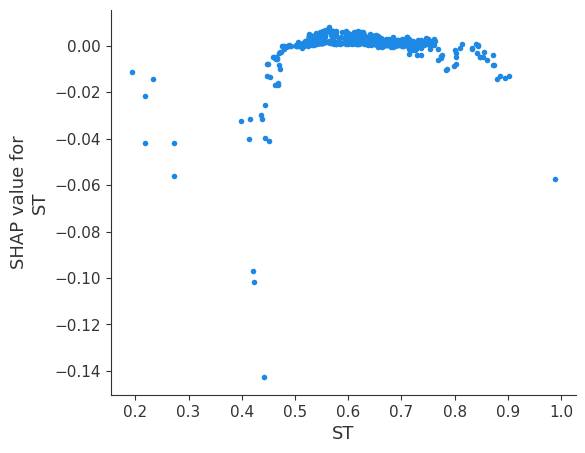

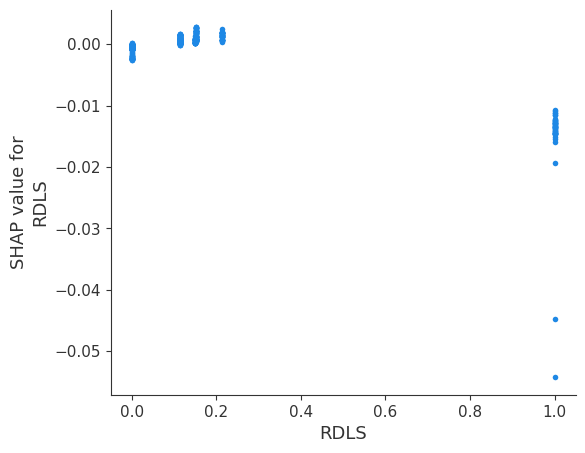

In [7]:

for col in cols:
    shap.dependence_plot(col, shap_values, X, feature_names=cols, interaction_index=None)
    plt.show()


In [63]:
import pandas as pd

data_test=pd.read_csv('predict.csv')# All points
daa=data_test.drop(['POINTID'], axis=1)# Remove id
daa=daa.drop(['OID_'], axis=1)
daa=daa.drop(['GRID_CODE'], axis=1)
#daa=daa.drop(['OBJECTID'], axis=1)
daa=daa.drop(['POINT_X'],axis=1)
daa=daa.drop(['POINT_Y'],axis=1)
#daa=daa.drop(['POINT_M'],axis=1)
#daa=daa.drop(['Shape'],axis=1)
yaa=rf.predict_proba(daa)
data_test.head()



,OID_,POINTID,GRID_CODE,Aspect,CV,Ele,DFAF,DFHS,DFR,DFW,...,PGA,Pre,RDLS,SE,SI,Slope,SM,ST,POINT_X,POINT_Y
0,1,0,2565,0.074169,0.642726,0.214686,0.119099,0.153639,0.418121,0.595100,...,0.666667,0.511009,0.012739,0.0,0.0,0.170485,0.717883,0.0,534756.2071,2.983235e+06
1,2,0,2574,0.058287,0.645171,0.216425,0.118573,0.154024,0.418232,0.595980,...,0.666667,0.510489,0.012314,0.0,0.0,0.234428,0.717883,0.0,534786.2071,2.983235e+06
2,3,0,2574,0.022701,0.643949,0.216425,0.118048,0.154408,0.418343,0.596860,...,0.666667,0.509970,0.012314,0.0,0.0,0.265483,0.717883,0.0,534816.2071,2.983235e+06
3,4,0,2573,0.995925,0.645171,0.216232,0.117524,0.154793,0.418454,0.597741,...,0.666667,0.509450,0.012739,0.0,0.0,0.281787,0.717883,0.0,534846.2071,2.983235e+06
4,5,0,2562,0.993548,0.645477,0.214106,0.117000,0.155178,0.418567,0.598621,...,0.666667,0.508930,0.014013,0.0,0.0,0.299552,0.717883,0.0,534876.2071,2.983235e+06


In [64]:
# Make a prediction
y_pred = rf.predict_proba(daa)[:, 1]

# Add the prediction result to the original data
data_test['score'] = y_pred

# Save the result as result.csv
data_test.to_csv('result.csv', index=False)
#print(max(daa['score']))
#print(min(daa['score']))

In [12]:
import matplotlib.pyplot as plt
import shap
from matplotlib import font_manager



for col in cols:
    fig, ax = plt.subplots(figsize=(12, 8)) 
    shap.dependence_plot(col, shap_values, X, feature_names=cols, interaction_index=None, ax=ax, show=False)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(f'Dependence Plot for {col}', fontsize=28)
    

    plt.savefig(f'D:\\Desktop\\c1\\{col}_dependence_plot.png', dpi=300)
    
    plt.close()
